<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/Regresion_ds_fede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# General libs
import pandas as pd
import numpy as np

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


Primero junto la data y limpio ( lineal y KNN  requieren numericos sin null ) \
Creo un unico dataset con las columnas x e y, dropeo los null \
Imprimo dataset antes y despues ( aprox 75% recortado <- REVISAR )

In [2]:
# Ruta donde van a estar todos los datasets
ruta = "https://raw.githubusercontent.com/sttesta3/7506R-1C2024-GRUPO08/fede/datasets/"
ds = pd.read_csv(ruta + "ds_filtrado.csv")

ds.info()

ds.drop(columns="start_date",inplace=True)
ds.drop(columns="place_l3",inplace=True)
ds.drop(columns="property_type",inplace=True)

from sklearn.model_selection import train_test_split
ds_train, ds_test = train_test_split(ds, test_size=0.2 , random_state=2)

ds_train.info()
ds_test.info()

x_train_knn=pd.DataFrame(ds_train, columns=["latitud","longitud","property_bedrooms","property_rooms","property_surface_total","property_surface_covered"])
y_train_knn = ds_train.property_price

x_test_knn = pd.DataFrame(ds_test, columns=["latitud","longitud","property_bedrooms","property_rooms","property_surface_total","property_surface_covered"])
y_test_knn = ds_test.property_price


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52366 entries, 0 to 52365
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start_date                52366 non-null  object 
 1   latitud                   52366 non-null  float64
 2   longitud                  52366 non-null  float64
 3   place_l3                  52366 non-null  object 
 4   property_type             52366 non-null  object 
 5   property_rooms            52366 non-null  int64  
 6   property_bedrooms         52366 non-null  int64  
 7   property_surface_total    52366 non-null  float64
 8   property_surface_covered  52366 non-null  float64
 9   property_price            52366 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 41892 entries, 39631 to 23720
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  --

ANalisis grafico y estadistico de correlaciones

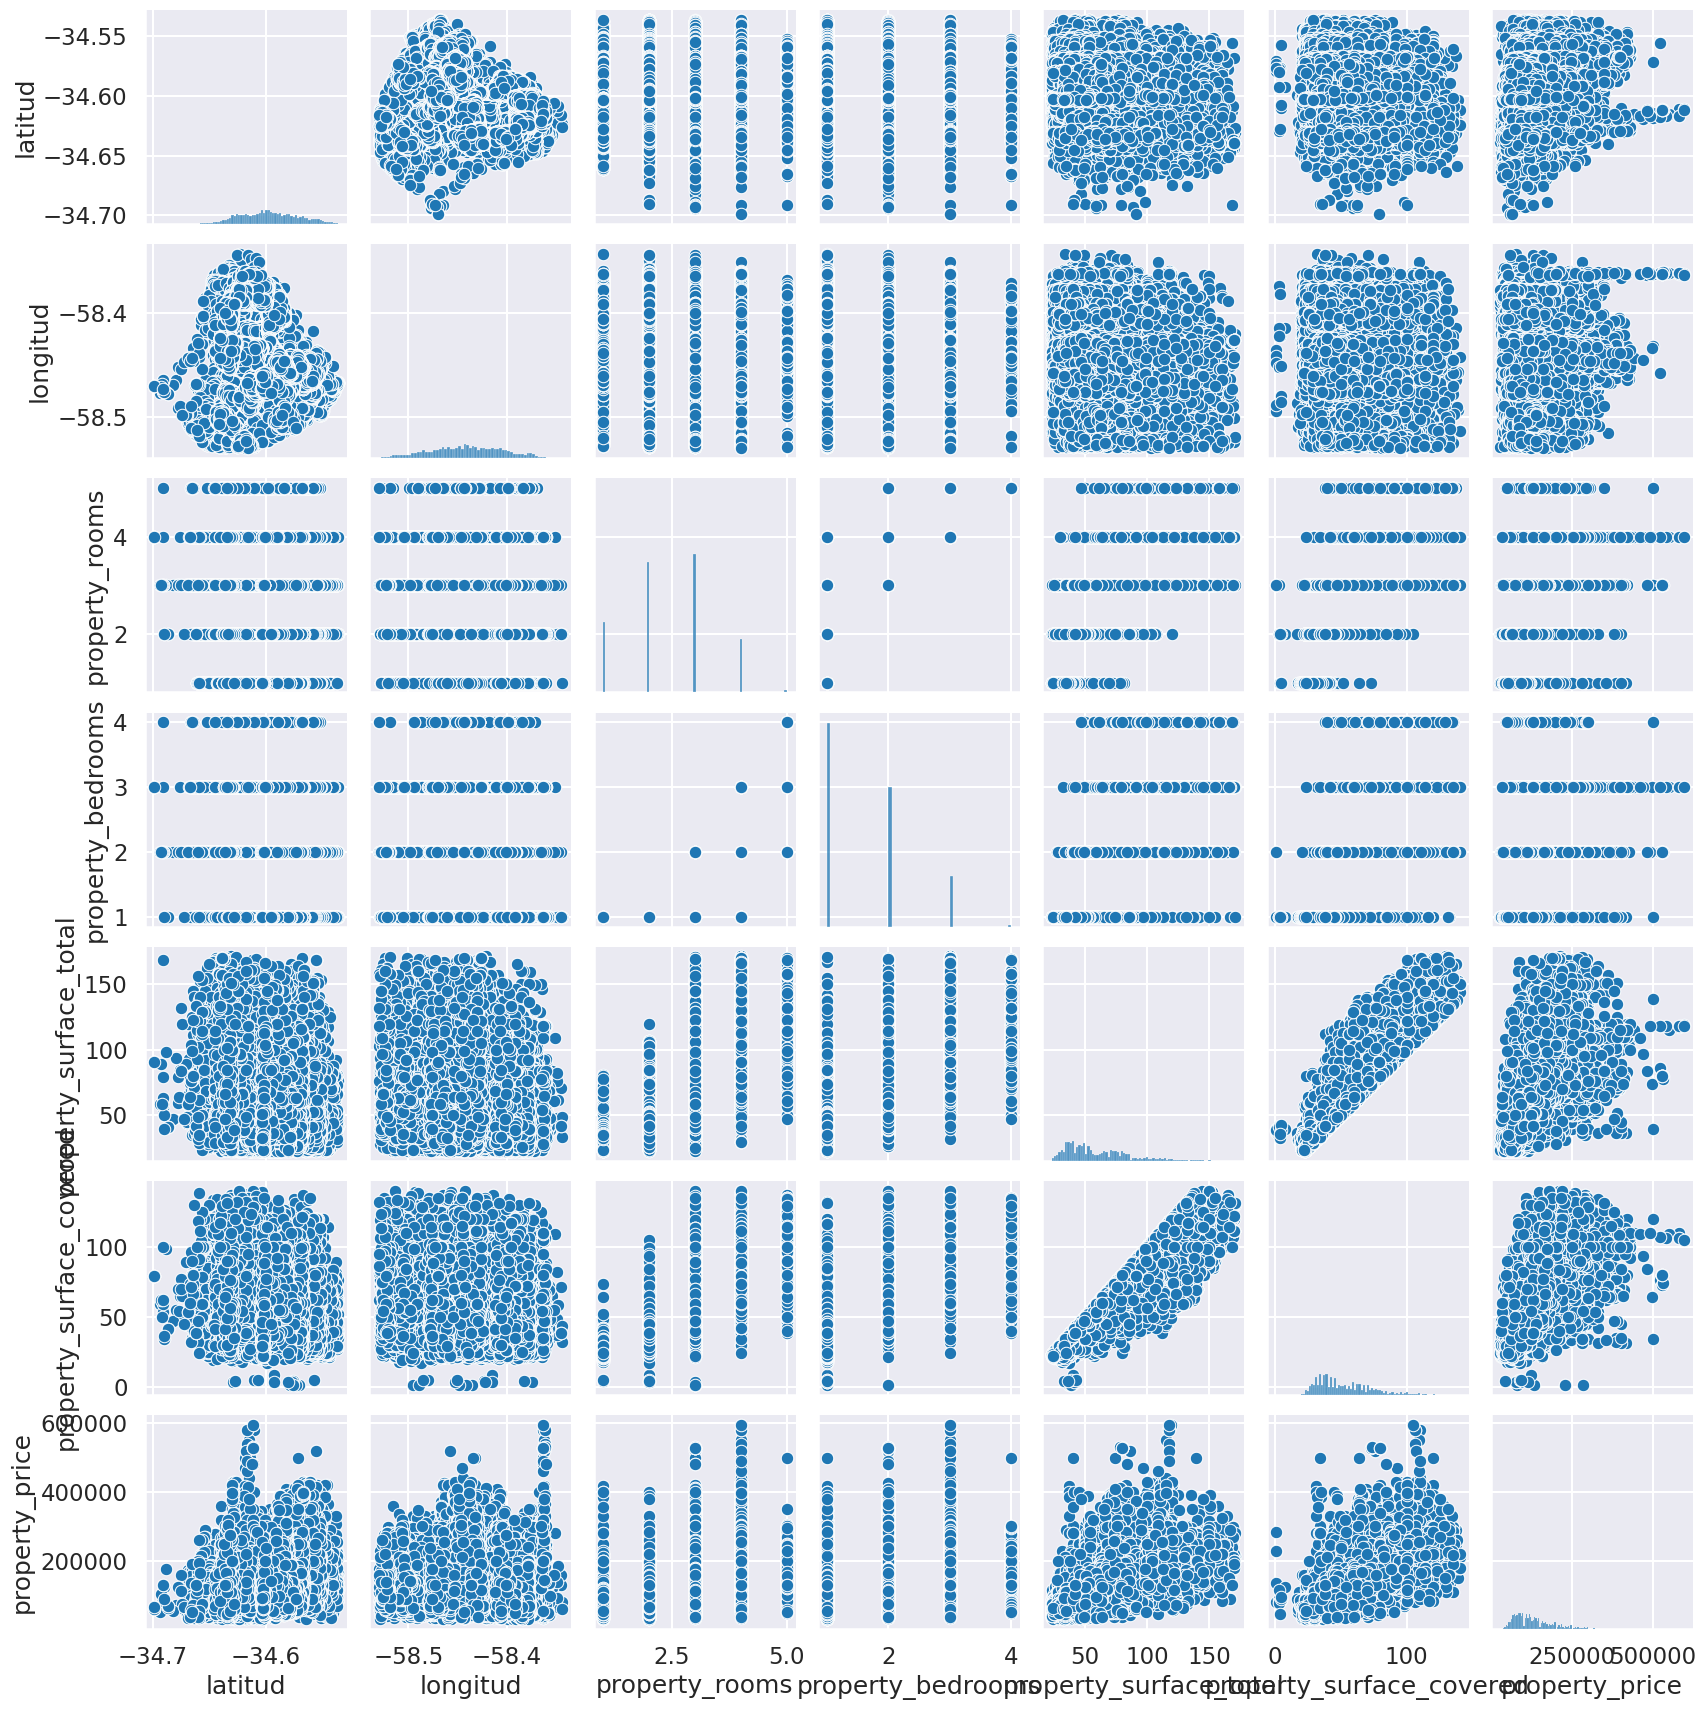

In [11]:
sns.pairplot(ds_train)

Pareceria que no modifico mucho, por lo menos cualitativamente, el dataset

In [17]:
ds_train.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.132406,-0.082406,-0.075763,-0.075142,-0.058522,0.219201
longitud,-0.132406,1.000000,-0.035846,-0.024256,-0.119834,-0.051776,-0.041025
property_rooms,-0.082406,-0.035846,1.000000,0.911769,0.821198,0.854963,0.627483
property_bedrooms,-0.075763,-0.024256,0.911769,1.000000,0.807896,0.843958,0.621392
property_surface_total,-0.075142,-0.119834,0.821198,0.807896,1.000000,0.936378,0.706231
property_surface_covered,-0.058522,-0.051776,0.854963,0.843958,0.936378,1.000000,0.733086
property_price,0.219201,-0.041025,0.627483,0.621392,0.706231,0.733086,1.000000


Entrenamiento

In [3]:
# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(x_train_knn, y_train_knn)
y_pred_knn=knn_regressor.predict(x_test_knn)
y_pred_knn

performance_knn = pd.DataFrame({'Valor Real': y_test_knn,
                            'Prediccion': y_pred_knn,
                            'Error': y_test_knn - y_pred_knn})
# View
performance_knn.head()

from sklearn import metrics

def errores_modelo( y_pred, y_test):
  mse = metrics.mean_squared_error(
          y_true  = y_test_knn,
          y_pred  = y_pred,
          squared = True
        )

  rmse = metrics.mean_squared_error(
          y_true  = y_test_knn,
          y_pred  = y_pred,
          squared = False
         )

  print(f"El error (mse) de test es: {mse}")
  print(f"El error (rmse) de test es: {rmse}")

errores_modelo( y_pred_knn, y_test_knn)
knn_regressor.score(x_test_knn,y_test_knn)



from sklearn.model_selection import cross_val_score

for i in range(5,16):
  scores = cross_val_score(knn_regressor, x_test_knn, y_test_knn, scoring="neg_mean_squared_error", cv=i)
  print(i, "| Mean:", round(scores.mean(),3), " | std:", round(scores.std(),3))


El error (mse) de test es: 1167342300.8941112
El error (rmse) de test es: 34166.39139408947
5 | Mean: -1526044354.281  | std: 26634924.672
6 | Mean: -1511567639.737  | std: 53653819.251
7 | Mean: -1516679996.067  | std: 109145861.314
8 | Mean: -1510655366.076  | std: 127844393.054
9 | Mean: -1502994005.006  | std: 89361689.193
10 | Mean: -1511070343.88  | std: 93518134.314
11 | Mean: -1505974908.881  | std: 150496834.584
12 | Mean: -1508013725.011  | std: 141214053.156
13 | Mean: -1501126687.315  | std: 120773065.581
14 | Mean: -1503823277.05  | std: 123340945.174
15 | Mean: -1502890269.977  | std: 153455248.27


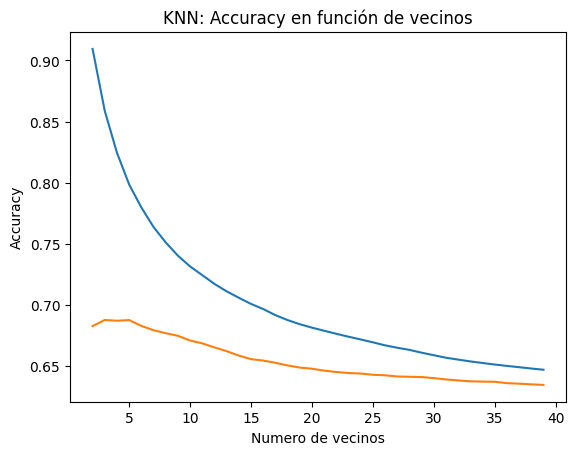

Cantidad de vecinos optima: 3 0.6874257098563473 Score entrenamiento:  0.8586977009690008


In [4]:
# Encontrando la mejor cantidad de vecinos con minkowski p=2
def vecinos_segun_hp_c_graf(pesos,algoritmo):
  scores_entrenamiento = []
  scores_test = []

  vecinos = np.arange(2,40,1)
  for vecino in vecinos:
    knn_tuning = KNeighborsRegressor(n_neighbors=vecino).fit(x_train_knn, y_train_knn)
    scores_entrenamiento.append(knn_tuning.score(x_train_knn,y_train_knn))
    scores_test.append(knn_tuning.score(x_test_knn,y_test_knn))

  plt.plot(vecinos, scores_entrenamiento, label="Entrenamiento Accuracy")
  plt.plot(vecinos, scores_test, label="Test Accuracy")
  plt.xlabel("Numero de vecinos")
  plt.ylabel("Accuracy")
  plt.title("KNN: Accuracy en función de vecinos")
  plt.show()

  print("Cantidad de vecinos optima:", scores_test.index(max(scores_test)) + 2,max(scores_test), "Score entrenamiento: ", scores_entrenamiento[scores_test.index(max(scores_test))])

vecinos_segun_hp_c_graf("uniform","auto")

In [ ]:
# Encontrando la mejor cantidad de vecinos con minkowski p=2
def vecinos_segun_hp(pesos,algoritmo,potencia,tamaño_hoja,cant_vecinos):
  knn_tuning = KNeighborsRegressor(n_neighbors=cant_vecinos,weights=pesos,algorithm=algoritmo,p=potencia).fit(x_train_knn, y_train_knn)
  print("Resultado en test: ",knn_tuning.score(x_test_knn,y_test_knn),"Resultado en entrenamiento:",knn_tuning.score(x_train_knn,y_train_knn))

for i in range(1,5):
  print("Potencia:",i)
  vecinos_segun_hp("uniform","brute",i,30,3)
  vecinos_segun_hp("distance","brute",i,30,3)


Potencia: 1
Resultado en test:  0.6871902494919917 Resultado en entrenamiento: 0.8581812057835545
Resultado en test:  0.7232853798023602 Resultado en entrenamiento: 0.9940325353859399
Potencia: 2
Resultado en test:  0.6876954450230801 Resultado en entrenamiento: 0.8585684022625478
Resultado en test:  0.7232874643552527 Resultado en entrenamiento: 0.994010262625618
Potencia: 3


In [ ]:
lr_model = LinearRegression().fit(x_train_knn, y_train_knn)
y_pred_lr = lr_model.predict(x_test_knn)

errores_modelo( y_pred_lr, y_test_knn)
lr_model.score(x_test_knn,y_test_knn)